# EDA on Lending Club dataset

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [2]:
pd.options.display.max_colwidth = 200

## Load Data

In [3]:
loan_data_df = pd.read_csv('loan.csv', low_memory=False)
column_desc_df = pd.read_excel('Data_Dictionary.xlsx')
loan_data_df.info()
before_cols = len(loan_data_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


## Data Cleanup

### Finding Columns having all Null or 90% Null data

 #### All Columns having 90% or more Null data

 **Note:** Following list will be the superset of previous list.

In [4]:
atleast_90pct_empty = loan_data_df.columns[~(loan_data_df.isnull().sum(axis=0) <= loan_data_df.shape[0] * 0.9)].tolist()
print(f"Columns with atleast 90% of empty columns are : {len(atleast_90pct_empty)}\n")
print(atleast_90pct_empty)

Columns with atleast 90% of empty columns are : 56

['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'perce

#### Columns having all Null

In [5]:
all_empty_cols= loan_data_df.columns[loan_data_df.isna().all()].tolist()
print(f"Total number of all empty columns are : {len(all_empty_cols)}\n")
print(all_empty_cols)

Total number of all empty columns are : 54

['mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tot_hi_cred_lim', 'total_bal_ex_mor

#### Delete all or 90% empty columns

In [6]:
# Remove all columns with null values
loan_data_df = loan_data_df.dropna(axis=1, how='all')
# Remove all columns with 90% null values
loan_data_df = loan_data_df.loc[:, (loan_data_df.isnull().sum(axis=0) <= loan_data_df.shape[0] * 0.9)]

### Remove columns which have constant as a value. 
These will become metadata for the dataset because the dataset has only one value for them.
eg. all values in column: pymnt_plan are `n`.

In [7]:
constant_cols_dict = { c : loan_data_df[c].value_counts().index[0] for c in loan_data_df.columns if loan_data_df[c].value_counts().count() == 1} 

print(f"Columns having constant values: {constant_cols_dict}\n")

print(f"Columns to be removed : {constant_cols_dict.keys()}\n")

loan_data_df.drop(columns=constant_cols_dict.keys(), inplace=True) 


Columns having constant values: {'pymnt_plan': 'n', 'initial_list_status': 'f', 'collections_12_mths_ex_med': 0.0, 'policy_code': 1, 'application_type': 'INDIVIDUAL', 'acc_now_delinq': 0, 'chargeoff_within_12_mths': 0.0, 'delinq_amnt': 0, 'tax_liens': 0.0}

Columns to be removed : dict_keys(['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'])



### Inspect and remove unwanted columns 
Some columns can be removed since they don't give much use to the analysis

In [8]:
print("desc, purpose, title are similar - title and desc seem to be human added and have more distinct values. Purpose has a finite list and it alone can be looked at and drop desc and title.")
print("\n-------title-----------\n", loan_data_df.title.value_counts().index, 
      # "\n-------desc----------\n", loan_data_df.desc.value_counts().index, # Too much data. skipping print
      "\n-------purpose-----------\n", loan_data_df.purpose.value_counts().index)
cols_to_drop = ['title', 'desc']
print("url column has external url for lending club, and not much use to analysys")
print(loan_data_df.url.head())
cols_to_drop.append('url')
loan_data_df.drop(columns=cols_to_drop, inplace=True) 

desc, purpose, title are similar - title and desc seem to be human added and have more distinct values. Purpose has a finite list and it alone can be looked at and drop desc and title.

-------title-----------
 Index(['Debt Consolidation', 'Debt Consolidation Loan', 'Personal Loan',
       'Consolidation', 'debt consolidation', 'Home Improvement',
       'Credit Card Consolidation', 'Debt consolidation',
       'Small Business Loan', 'Credit Card Loan',
       ...
       'Stav', 'Florida Vacation 2011', 'Ninja zx6', 'Pay off Masters Degree',
       'CREDIT CARD CONSOLIDATION LOAN 01', 'your rate is better than my rate',
       'Concession Trailer', 'gregs', 'EZover', 'JAL Loan'],
      dtype='object', length=19615) 
-------purpose-----------
 Index(['debt_consolidation', 'credit_card', 'other', 'home_improvement',
       'major_purchase', 'small_business', 'car', 'wedding', 'medical',
       'moving', 'vacation', 'house', 'educational', 'renewable_energy'],
      dtype='object')
url co

#### Dataset after removed columns

In [9]:
print(f"The no. columns are reduced from {before_cols} to {len(loan_data_df.columns)}")

The no. columns are reduced from 111 to 43


In [10]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

In [11]:
loan_data_df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,May-16,0.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,May-16,0.0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,Apr-16,0.0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,3513.33,2475.94,1037.39,0.00,0.00,0.00,May-16,67.79,May-16,0.0


### Convert the columns to correct datatypes

In [12]:
from datetime import date, datetime
def convert_emp_length(l):
    if pd.isna(l):
        return np.nan
    elif l == '< 1 year':
        return 0
    elif l == '10+ years':
        return 10
    else:
        return int(str(l)[0])

def convert_period_to_date(p):
    if type(p) == datetime:
        return p
    period_parts = p.split('-')
    return datetime( int(f"19{period_parts[1]}" if int(period_parts[1]) > 30 else f"20{period_parts[1]}") ,  datetime.strptime(period_parts[0],'%b').month, 1) 

In [13]:
# numbers
loan_data_df.term               = loan_data_df.term.apply(lambda x: int(str(x)[:3]))
loan_data_df.emp_length         = loan_data_df.emp_length.apply(convert_emp_length) 
# percentages
loan_data_df.int_rate           = loan_data_df.int_rate.apply(lambda x: float(str(x)[:-1])/100)
loan_data_df.revol_util         = loan_data_df.revol_util.apply(lambda x: (float(str(x)[:-1])/100) if str(x) != 'nan' else x)
# dates
loan_data_df.issue_d            = pd.to_datetime(loan_data_df.issue_d, format='%b-%y')
loan_data_df.last_pymnt_d       = pd.to_datetime(loan_data_df.last_pymnt_d, format='%b-%y')
loan_data_df.last_credit_pull_d = pd.to_datetime(loan_data_df.last_credit_pull_d, format='%b-%y')
# only years 69-99 will be added with 20th century(19xx) padding in python
# ref: https://docs.python.org/3/library/time.html#:~:text=values%2069%E2%80%9399%20are%20mapped%20to%201969%E2%80%931999%2C%20and%20values%200%E2%80%9368%20are%20mapped%20to%202000%E2%80%932068.
loan_data_df.earliest_cr_line   = loan_data_df.earliest_cr_line.apply(convert_period_to_date) 


### Remove/add value to rows with null values in certain columns

In [14]:
loan_data_df.isna().sum()[loan_data_df.isna().sum() > 0]

emp_title                  2459
emp_length                 1075
mths_since_last_delinq    25682
revol_util                   50
last_pymnt_d                 71
last_credit_pull_d            2
pub_rec_bankruptcies        697
dtype: int64

Remove rows with very few (<100) NaNs

In [15]:
cols_with_few_nan_rows = list(loan_data_df.isna().sum()[(loan_data_df.isna().sum() < 700) & (loan_data_df.isna().sum() > 0)].index)
for col in cols_with_few_nan_rows:
    loan_data_df.drop(loan_data_df[loan_data_df[col].isna()].index, inplace=True)

The borrowers who have not been delinquated forever, we are setting higher value than the max avialable in dataset. 

In [16]:
loan_data_df.mths_since_last_delinq.fillna(value=1000, inplace=True)
loan_data_df.mths_since_last_delinq.value_counts()

1000.0    25594
30.0        245
15.0        241
23.0        241
24.0        235
          ...  
89.0          1
107.0         1
85.0          1
97.0          1
95.0          1
Name: mths_since_last_delinq, Length: 96, dtype: int64

The borrowers who do not have employment length are missing values. We are deleting those rows.

In [17]:
loan_data_df.drop(loan_data_df[loan_data_df['emp_length'].isna()].index, inplace=True)

In [18]:
print("Columns with non-zero NaN values left:")
loan_data_df.isna().sum()[loan_data_df.isna().sum() > 0]

Columns with non-zero NaN values left:


emp_title    1393
dtype: int64

## Derived Metrics

In [19]:
# Ratio of installment to monthly income
loan_data_df['installment_to_month_inc'] = pd.cut(loan_data_df['installment'] / (loan_data_df['annual_inc']/12), bins=np.linspace(0,0.3,15)) 
# Ratio of open acc to total acc
loan_data_df['open_to_total_acc'] = pd.cut(loan_data_df['open_acc'] / loan_data_df['total_acc'], bins=np.linspace(0,1,11))
# Representing loan_status as a numeric value
loan_data_df['loan_status_n'] = loan_data_df['loan_status'].map({'Charged Off': -1, 'Fully Paid': 1, 'Current': 0})

### Categorising Annual income, loan_amount, interest_rate

loan_data_df['annual_inc_range'] = pd.cut(loan_data_df.annual_inc, 
                                          bins=[1000, 10000, 50000, 100000, 500000, 1000000, 10000000], 
                                          labels=['below 10k','10k-50k','50k-100k','100k-500k', '500k-1M', '1M+'])
loan_data_df['loan_amnt_range']  = pd.cut(loan_data_df.loan_amnt, 
                                          bins=[100, 1000, 5000, 10000, 25000, 50000], 
                                          labels=['below 1k','1k-5k','5k-10k','10k-25k', '25k+'])
loan_data_df['int_rate_range']   = pd.cut(loan_data_df.int_rate, 
                                          bins=[0, 0.07, 0.14, 0.21, 0.3], 
                                          labels=['below 7%','7-14%','14-21%','21+%'])


### Final Data Dictionary

In [20]:
column_desc_df = column_desc_df[column_desc_df.LoanStatNew.isin(loan_data_df.columns)]
column_desc_df.reset_index(inplace=True)

In [21]:
column_desc_df.loc[:, ['LoanStatNew', 'Description']]

,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan application
1,annual_inc,The self-reported annual income provided by the borrower during registration.
2,collection_recovery_fee,post charge off collection fee
3,delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
4,dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly inc..."
5,earliest_cr_line,The month the borrower's earliest reported credit line was opened
6,emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
7,emp_title,The job title supplied by the Borrower when applying for the loan.*
8,funded_amnt,The total amount committed to that loan at that point in time.
9,funded_amnt_inv,The total amount committed by investors for that loan at that point in time.


## Find and remove outliers

[Annual Income] Rows <99%ile(189000.00): 37075
[Annual Income] Rows < 2M$: 37833
[Loan Amount] Rows <98%ile(32000.00): 37067
LoanAmount < 98%ile and Annual income < 98%ile: num of rows: 36409
 total rows: 37835


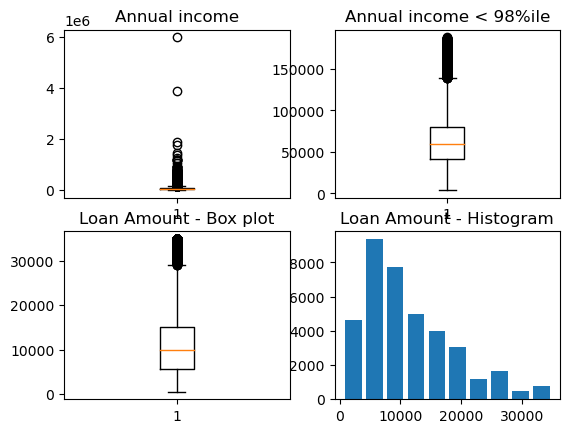

In [22]:
plt.subplot(2, 2, 1)
plt.subplot(2, 2, 1).set_title('Annual income')
plt.boxplot(loan_data_df.annual_inc)

plt.subplot(2, 2, 2)
plt.subplot(2, 2, 2).set_title('Annual income < 98%ile')
plt.boxplot(loan_data_df.annual_inc[loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98)])


print("[Annual Income] Rows <99%%ile(%.2f): %d" % (loan_data_df.annual_inc.quantile(0.98), (loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98)).sum()))
print("[Annual Income] Rows < 2M$: %d" % ((loan_data_df.annual_inc < 2000000).sum()))

plt.subplot(2, 2, 3)
plt.subplot(2, 2, 3).set_title('Loan Amount - Box plot')
plt.boxplot(loan_data_df.loan_amnt)

plt.subplot(2, 2, 4)
plt.subplot(2, 2, 4).set_title('Loan Amount - Histogram')
plt.hist(loan_data_df.loan_amnt, rwidth=0.8)

print("[Loan Amount] Rows <98%%ile(%.2f): %d" % (loan_data_df.loan_amnt.quantile(0.98), (loan_data_df.loan_amnt < loan_data_df.loan_amnt.quantile(0.98)).sum()))

print("LoanAmount < 98%%ile and Annual income < 98%%ile: num of rows: %d" % (loan_data_df[(loan_data_df.loan_amnt < loan_data_df.loan_amnt.quantile(0.98)) &
                                                                                        (loan_data_df.annual_inc < loan_data_df.annual_inc.quantile(0.98))].shape[0]))
print(f" total rows: {loan_data_df.shape[0]}")

plt.show()

There is a clear gap in annual income for entries above 2M\\$ with just two entries at 4M\\$ and 6M\\$ respectively. We can ignore those
After removing rows that have outliers from above, we get below:

In [23]:
loan_data_df = loan_data_df[loan_data_df.annual_inc < 2000000]

## Analyze columns of interest

### Find relation between all money columns

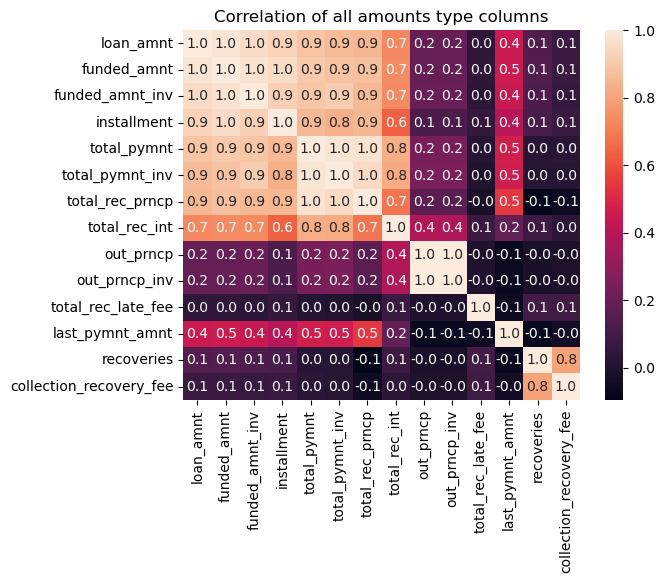

In [24]:
c = loan_data_df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'out_prncp', 'out_prncp_inv', 
                  'total_rec_late_fee', 
                  'last_pymnt_amnt', 
                  'recoveries', 'collection_recovery_fee']].corr()
plt.title("Correlation of all amounts type columns")
sns.heatmap(c, annot=True, fmt=".1f")
plt.show()

#### Ignoring Investor specific and recovery data columns
Since lending club is an investor backed P2P lending service, we can ignore the columns like funded_amnt, funded_amnt_inv, total_pymnt_inv, out_prncp_inv. 

Also we will focus on loan related amounts rather than late / recovery details are only related to each other. 

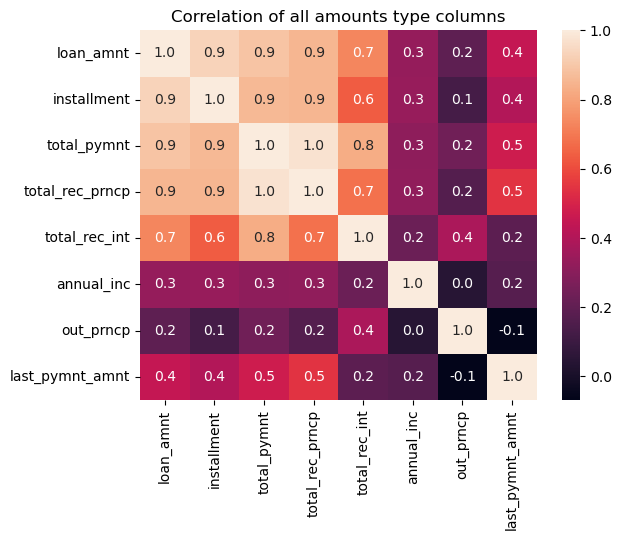

In [25]:
c = loan_data_df[['loan_amnt',  'installment', 'total_pymnt',  'total_rec_prncp', 'total_rec_int', 'annual_inc',
                  'out_prncp',
                   
                  'last_pymnt_amnt']].corr()
plt.title("Correlation of all amounts type columns")
sns.heatmap(c, annot=True, fmt=".1f")
plt.show()

From the above graph, we see these group of columns highly correlated: <br>
G1: 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int' <br>
G2: 'out_prncp', 'out_prncp_inv' <br>
G3: 'recoveries', 'collection_recovery_fee' <br>
rest are not that related to each other.

**Note** : On the contrary of conventional idea, the Annual income and loan amount are very weakly related. 
 

<Axes: >

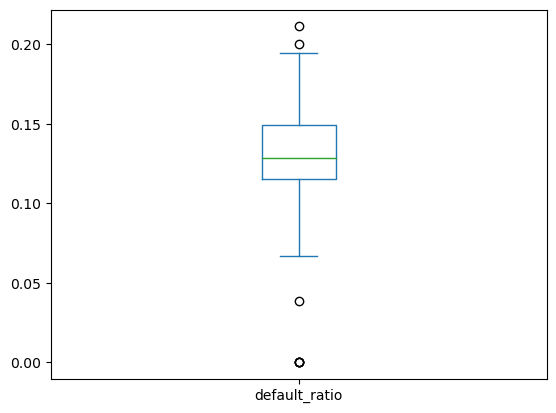

In [26]:
# plot of default ratio to the total loans given per state. 

loan_data_df.groupby(['addr_state']).agg(default_ratio=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.box()

### Distribution of loans per state

<Axes: >

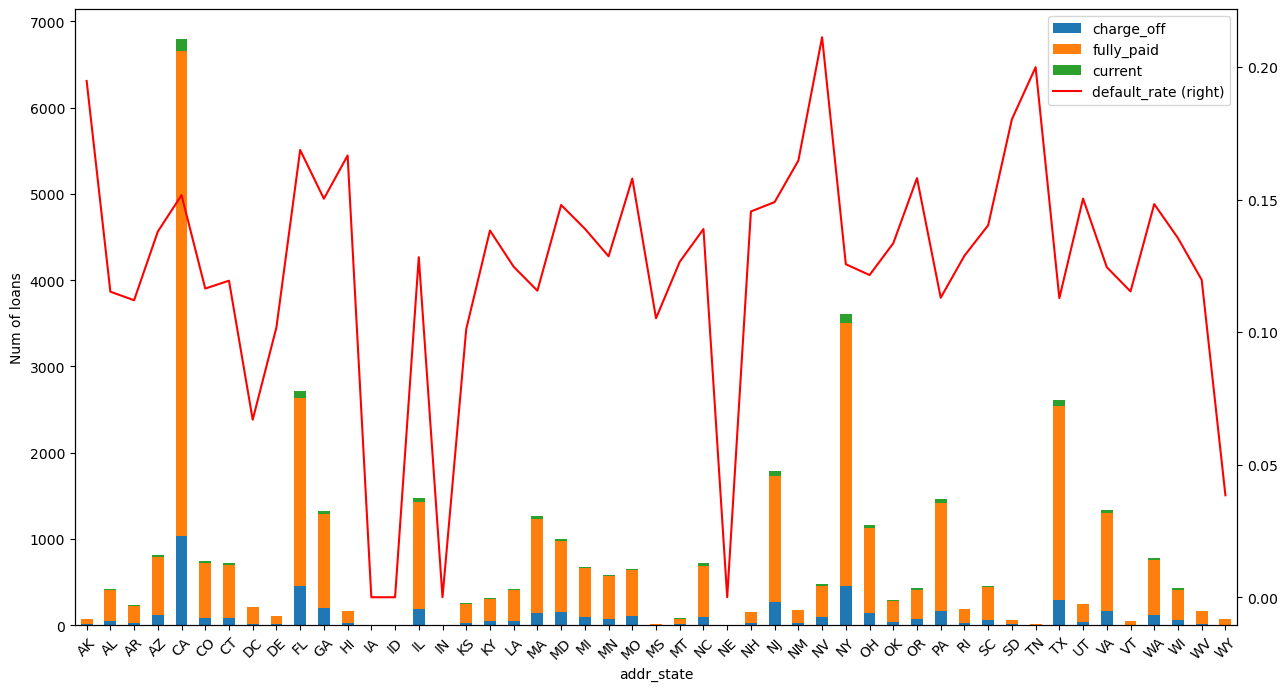

In [27]:
ax = loan_data_df.groupby(['addr_state']).agg(
                                         # avg_income=('annual_inc', 'mean'), 
                                         # num_of_loans=('id', 'count'), 
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='State', ylabel='Num of loans', figsize=(15, 8))

loan_data_df.groupby(['addr_state']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r', rot=45)

#### Summary

75 percentile of states are having default rate of around 0.15, so combining both visualizations, following states could be explored for more segmentation,
* FL
* HI
* NV
* TN
* SD

to understand what's causing the defaults at higher rate.

-- Include in insight


### Distribution of Average loan amount and Annual Income

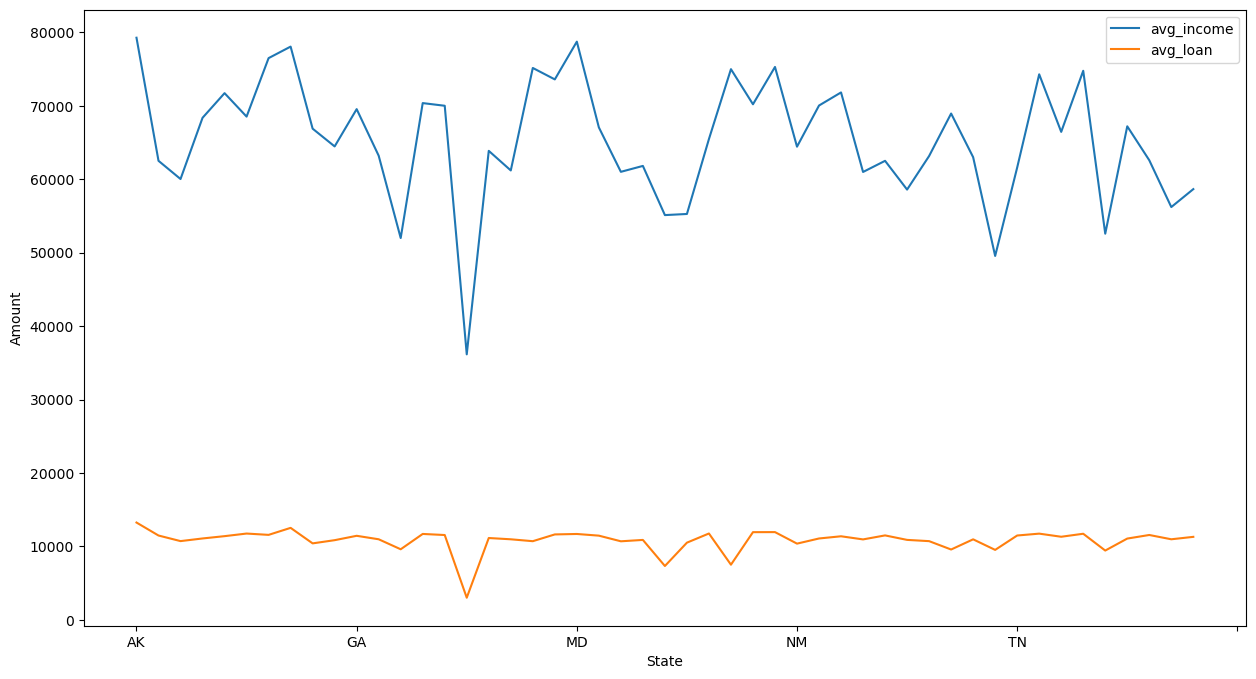

In [28]:
ax = loan_data_df.groupby(['addr_state']).agg(
                                         avg_income=('annual_inc', 'mean'),
                                         avg_loan=('loan_amnt', 'mean'),
                                        ).plot.line( xlabel='State', ylabel='Amount', figsize=(15, 8))


### Distribution of types of loan_statuses on different params

<Axes: >

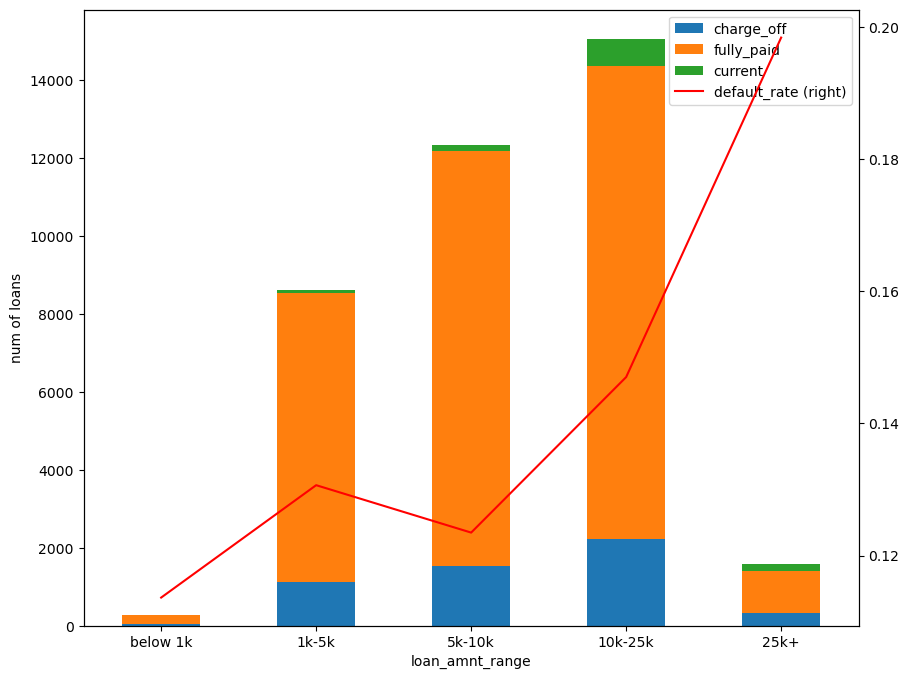

In [29]:
ax = loan_data_df.groupby(['loan_amnt_range']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='loan amount', ylabel='num of loans', figsize=(10, 8))
loan_data_df.groupby(['loan_amnt_range']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')


<Axes: >

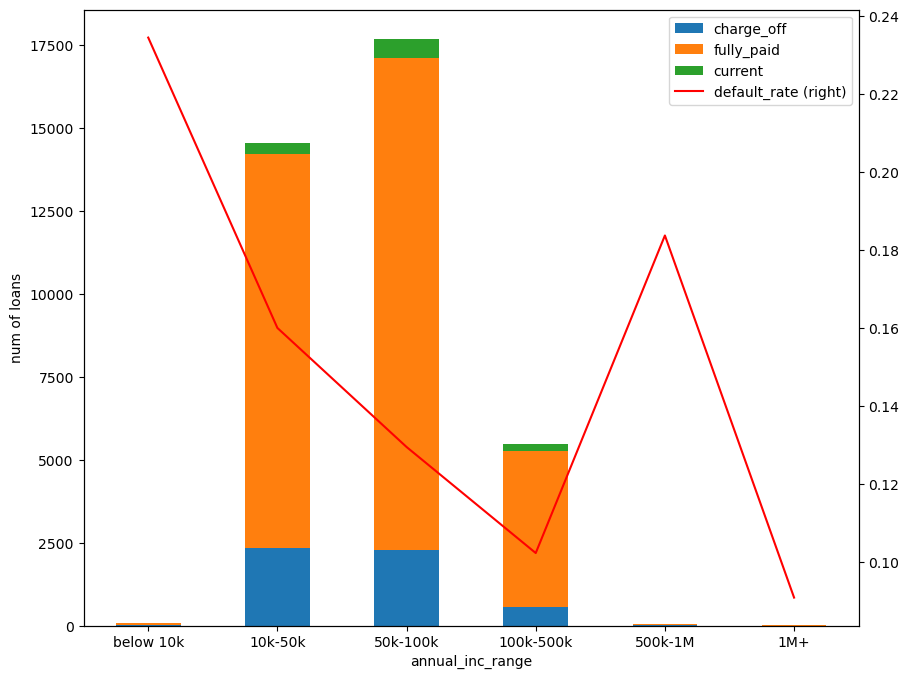

In [30]:
ax = loan_data_df.groupby(['annual_inc_range']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='annual income', ylabel='num of loans', figsize=(10, 8))

loan_data_df.groupby(['annual_inc_range']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')


<Axes: >

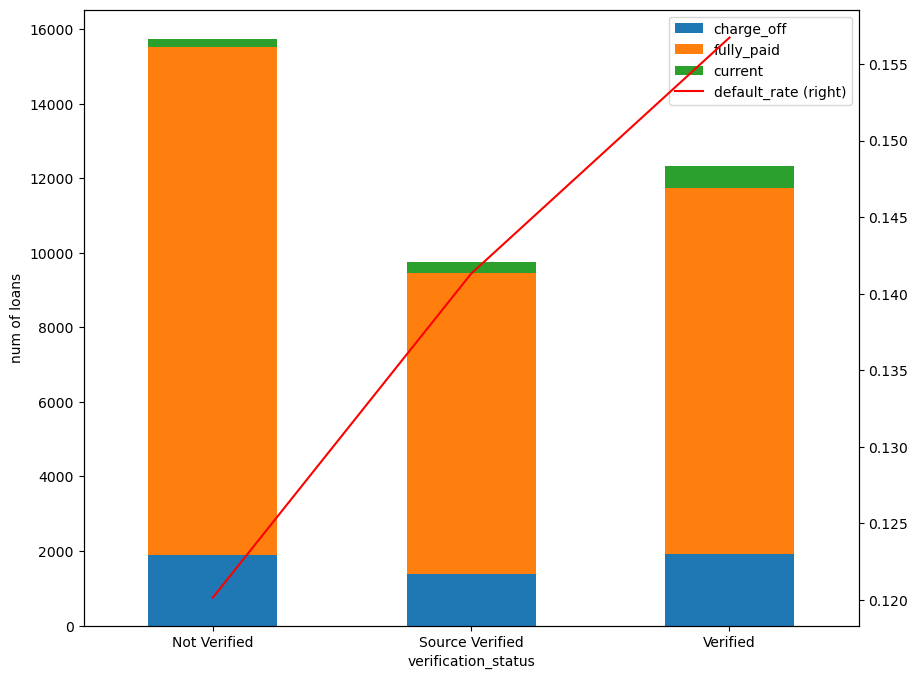

In [31]:
ax = loan_data_df.groupby(['verification_status']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='verification status', ylabel='num of loans', figsize=(10, 8))
loan_data_df.groupby(['verification_status']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')


#### Summary

Verified status does not have much impact on the probability of default. We need to dig deeper to confirm this fact / bias.


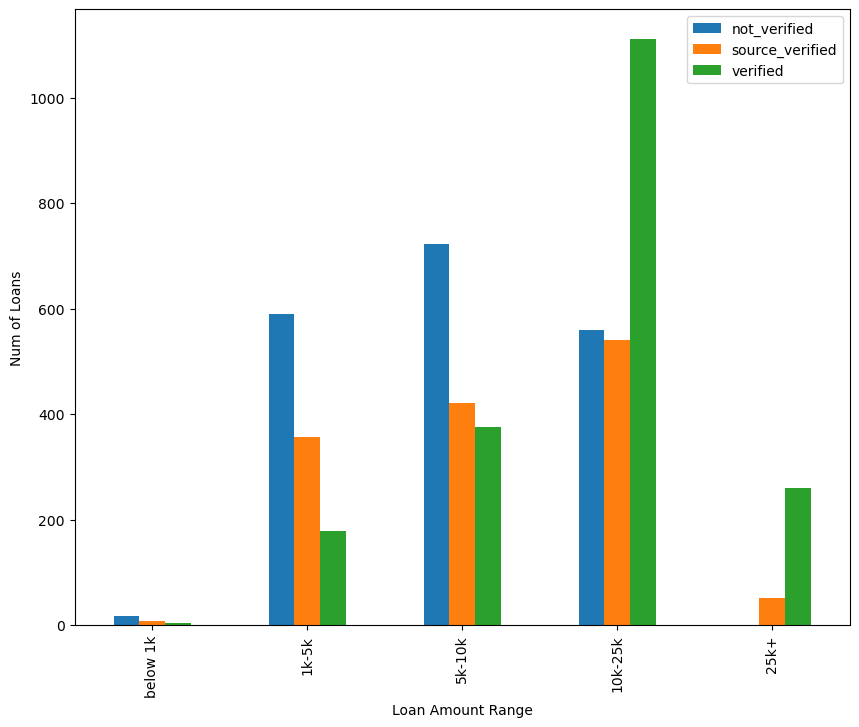

In [32]:
ax = loan_data_df[loan_data_df.loan_status=='Charged Off'].groupby(['loan_amnt_range']).agg(
                                         not_verified=('verification_status', lambda x: (x=='Not Verified').sum()),
                                         source_verified=('verification_status', lambda x: (x=='Source Verified').sum()),
                                         verified=('verification_status', lambda x: (x=='Verified').sum()),
                                        ).plot.bar(stacked=False, xlabel='Loan Amount Range', ylabel='Num of Loans', figsize=(10, 8))
#loan_data_df.groupby(['verification_status']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')


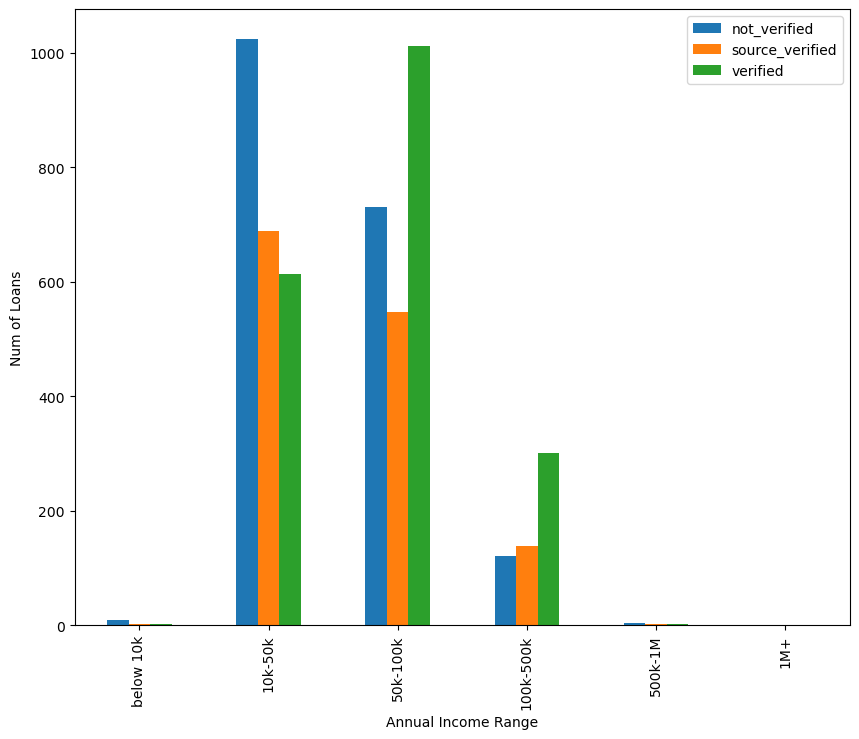

In [49]:
ax = loan_data_df[loan_data_df.loan_status=='Charged Off'].groupby(['annual_inc_range']).agg(
                                         not_verified=('verification_status', lambda x: (x=='Not Verified').sum()),
                                         source_verified=('verification_status', lambda x: (x=='Source Verified').sum()),
                                         verified=('verification_status', lambda x: (x=='Verified').sum()),
                                        ).plot.bar(stacked=False, xlabel='Annual Income Range', ylabel='Num of Loans', figsize=(10, 8))
# loan_data_df.groupby(['annual_inc_range']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')

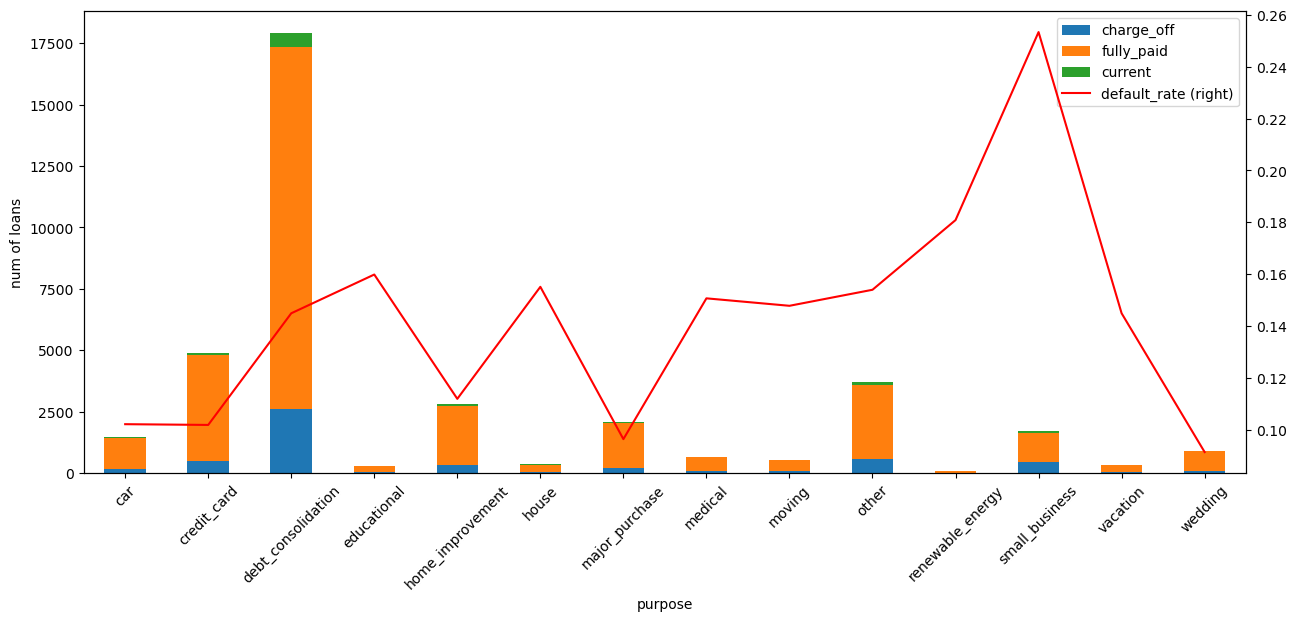

In [34]:
ax = loan_data_df.groupby(['purpose']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='purpose of loan', ylabel='num of loans', figsize=(15, 6))

loan_data_df.groupby(['purpose']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r', rot=45)
plt.show()

<Axes: >

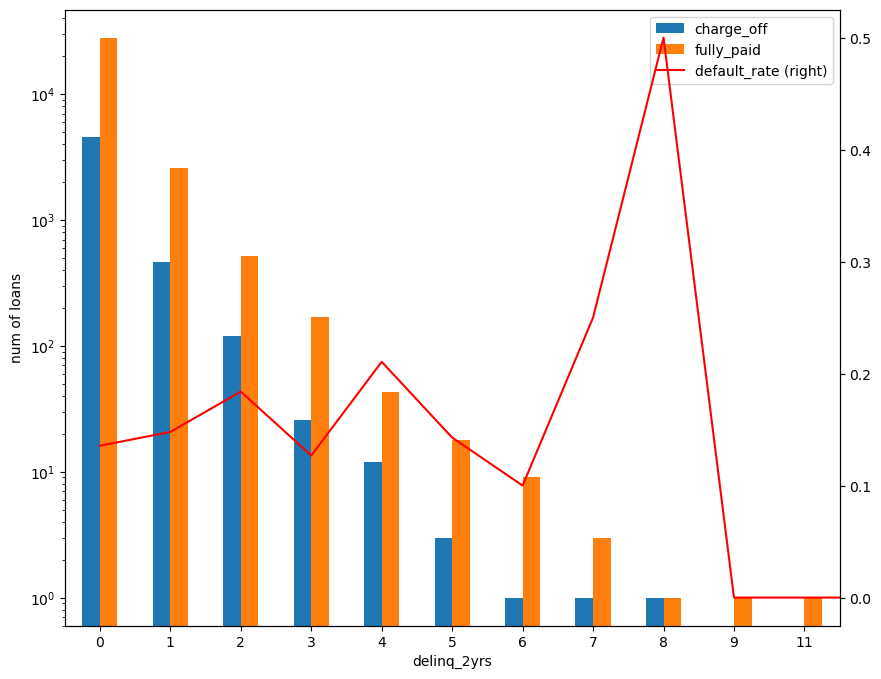

In [35]:
ax = loan_data_df.groupby(['delinq_2yrs']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         # current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=False, xlabel='delinq in 2yrs', ylabel='num of loans', logy=True, figsize=(10, 8))

loan_data_df.groupby(['delinq_2yrs']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')


#### Summary

In the current dataset, the measure : delinquency in last 2 years is not a very useful information because even for zero deliquant borrowers, there 10% of loans are charged off.

Yes when the no. of delinquency instances increase, the ratio does got up but the number of loans are so less, we can not conclude accurately.

It seems that Lending club is already considering this measure while approving the loans and hardly 2% to 3% of total loans are given when there is one of more delinquency instances.

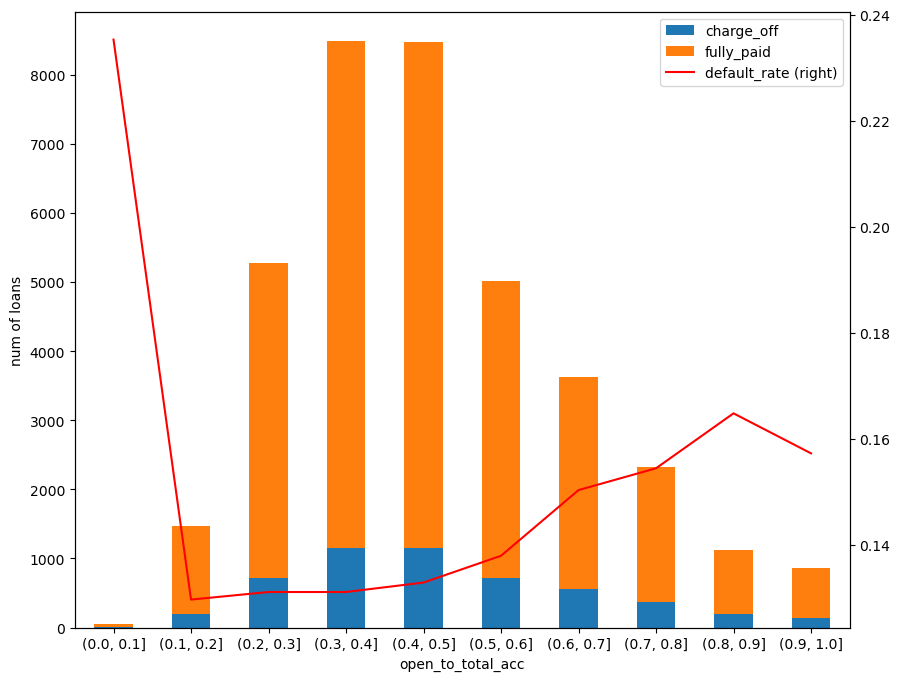

In [36]:
# 'installment_to_month_inc'
ax = loan_data_df.groupby(['open_to_total_acc']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         # current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, xlabel='ratio of open to total accounts', ylabel='num of loans', figsize=(10, 8))
loan_data_df.groupby(['open_to_total_acc']).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r')
plt.show()

<Axes: >

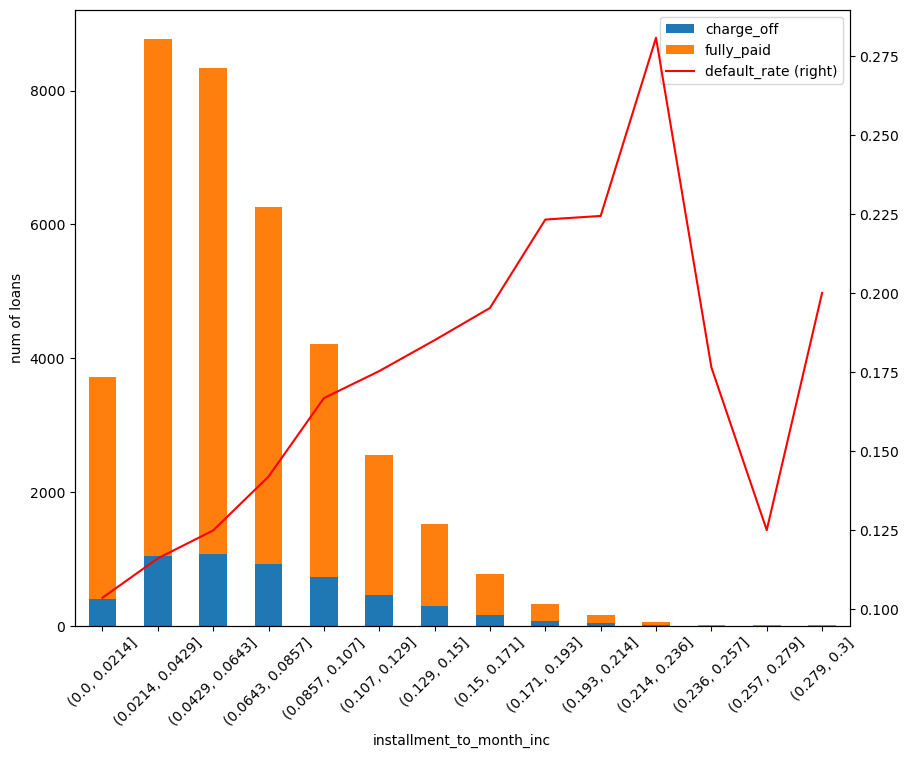

In [37]:
ax = loan_data_df.groupby(['installment_to_month_inc']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                        ).plot.bar(stacked=True, xlabel='installment to monthly income ratio', ylabel='num of loans', figsize=(10, 8))

loan_data_df.groupby(['installment_to_month_inc']).agg(
    default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r', rot=45)


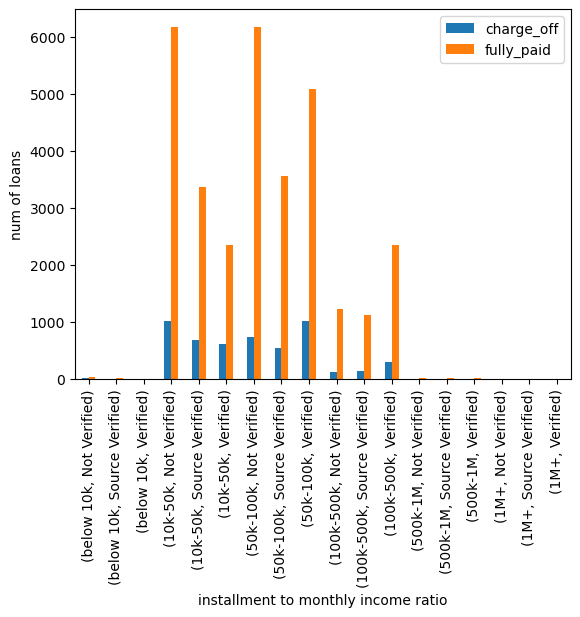

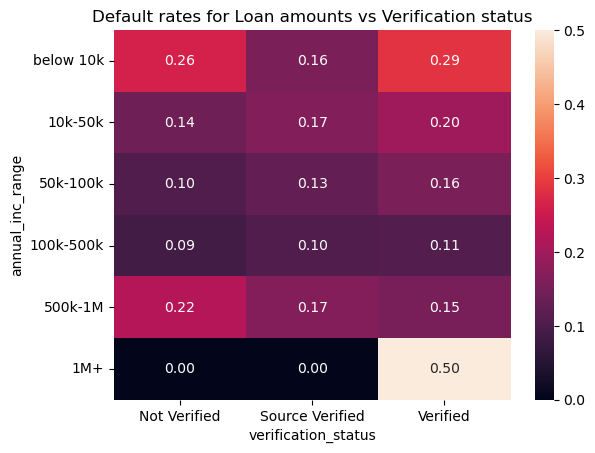

In [38]:
loan_data_df.groupby(['annual_inc_range','verification_status']).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                        ).plot.bar(xlabel='installment to monthly income ratio', ylabel='num of loans')


loan_data_df.groupby(['annual_inc_range', 'verification_status']).agg(
    default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax, color='r', rot=45)
plt.show()

c = pd.pivot_table(loan_data_df, index='annual_inc_range', columns='verification_status', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count())
plt.title('Default rates for Loan amounts vs Verification status')
sns.heatmap(c, annot=True, fmt=".2f")
plt.show()


verification_status               Not Verified  Source Verified  Verified
annual_inc_range loan_amnt_range                                         
below 10k        below 1k                    2                1         0
                 1k-5k                       8                2         2
                 5k-10k                      0                0         0
                 10k-25k                     0                0         0
                 25k+                        0                0         0
10k-50k          below 1k                   14                6         4
                 1k-5k                     387              246       107
                 5k-10k                    417              235       180
                 10k-25k                   207              201       316
                 25k+                        0                1         7
50k-100k         below 1k                    2                1         0
                 1k-5k                

<Axes: xlabel='verification_status', ylabel='loan_amnt_range'>

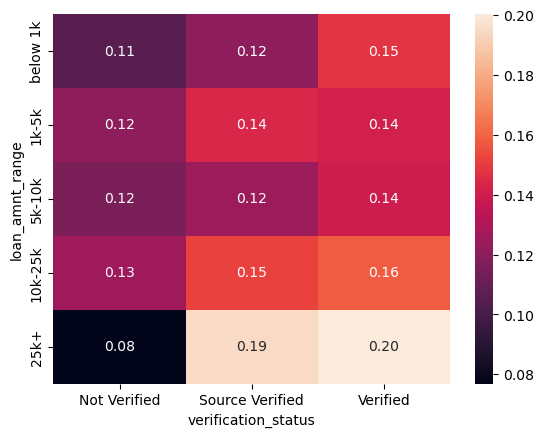

In [39]:
print(pd.pivot_table(loan_data_df[loan_data_df['loan_status'] == 'Charged Off'], index=['annual_inc_range', 'loan_amnt_range'], columns='verification_status', values='loan_status_n', aggfunc='count'))
c = pd.pivot_table(loan_data_df, index='loan_amnt_range', columns='verification_status', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count())
sns.heatmap(c, annot=True, fmt=".2f")

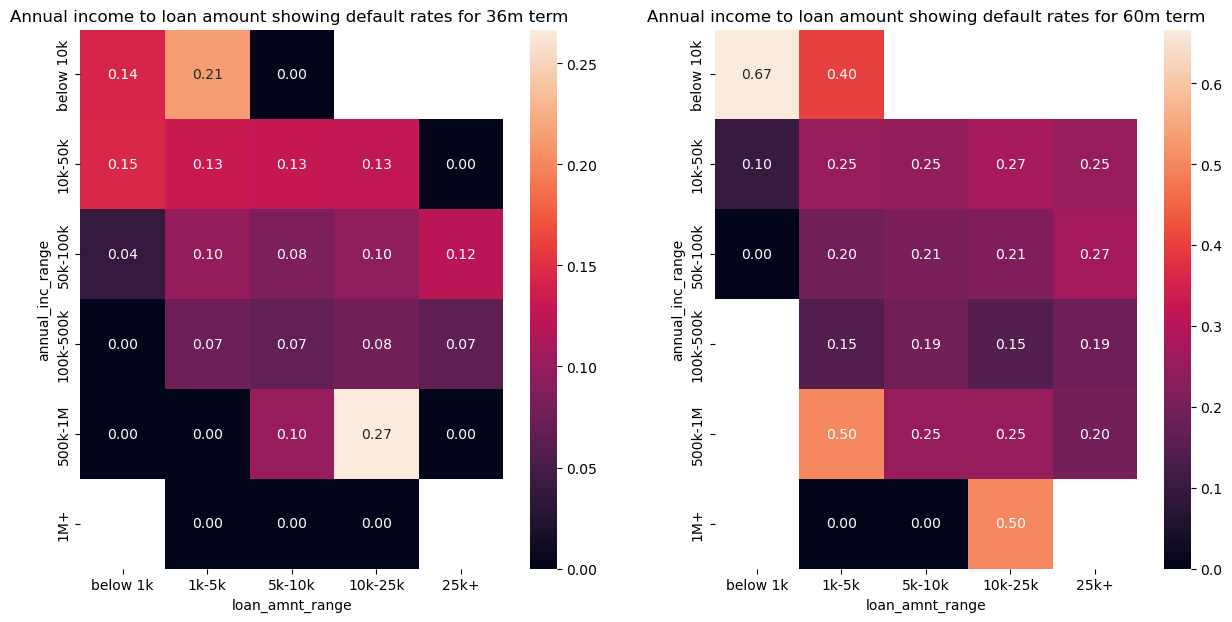

In [40]:
# Taking a loan with more than 30% of annual inc makes the probability of charge off higher.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
c = pd.pivot_table(loan_data_df[loan_data_df.term == 36], index='annual_inc_range', columns='loan_amnt_range', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count())
sns.heatmap(c, annot=True, fmt=".2f", ax=ax1)
ax1.set_title('Annual income to loan amount showing default rates for 36m term ')

c = pd.pivot_table(loan_data_df[loan_data_df.term == 60], index='annual_inc_range', columns='loan_amnt_range', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count())
sns.heatmap(c, annot=True, fmt=".2f", ax=ax2)
ax2.set_title('Annual income to loan amount showing default rates for 60m term')
plt.show()


<Axes: xlabel='annual_inc_range', ylabel='Default rate'>

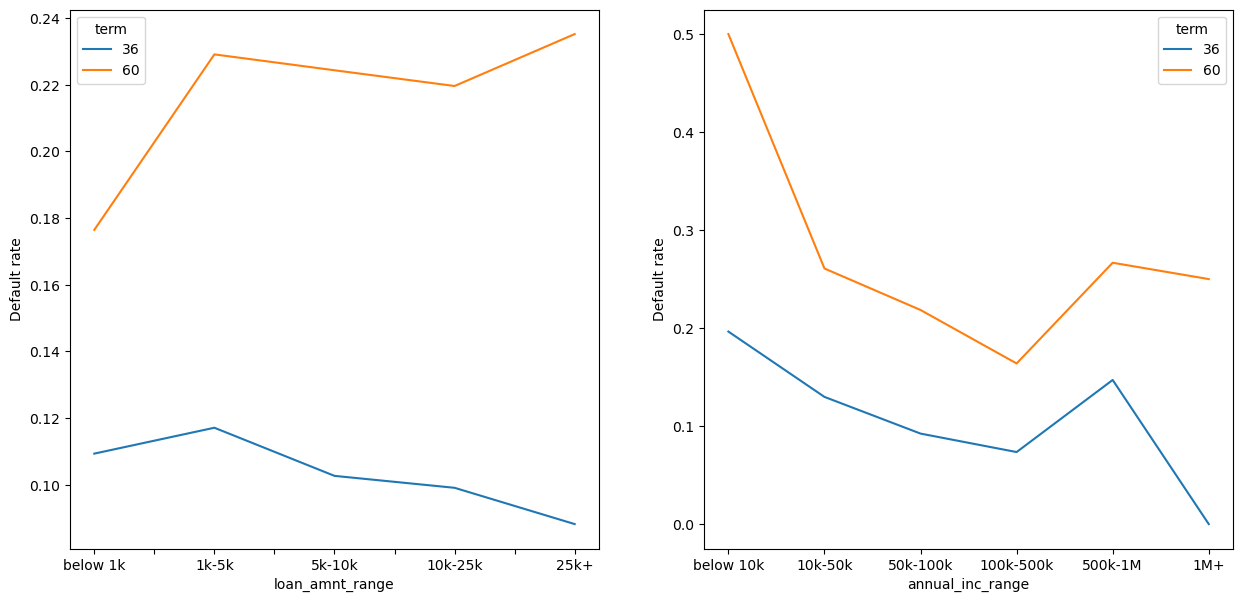

In [41]:
# higher loan term makes the probability of charge off higher for larger loan amounts
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
pd.pivot_table(loan_data_df, index='loan_amnt_range', columns='term', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count()).plot.line(ax=ax1, ylabel='Default rate')

pd.pivot_table(loan_data_df, index='annual_inc_range', columns='term', values='loan_status', aggfunc=lambda x: (x=='Charged Off').sum() / x.count()).plot.line(ax=ax2, ylabel='Default rate')

#### Summary

The loan term has a positive correlation with "charged off" probability. 

Higher the tenure and higher the loan amount, are positvely correlated with the probability of charged off.

and higher tenure (i.e. 60 months) would always higher probablity of charged off compared to lower tenure (i.e. 36 months) regardless of the loan amount.

In general higher tenure loans recover high portion of interest in initial 50% of time and that may be the reason.

-- Insight

Text(0.5, 1.0, 'Fraction repaid vs num of defaulted loans (loan term=60)')

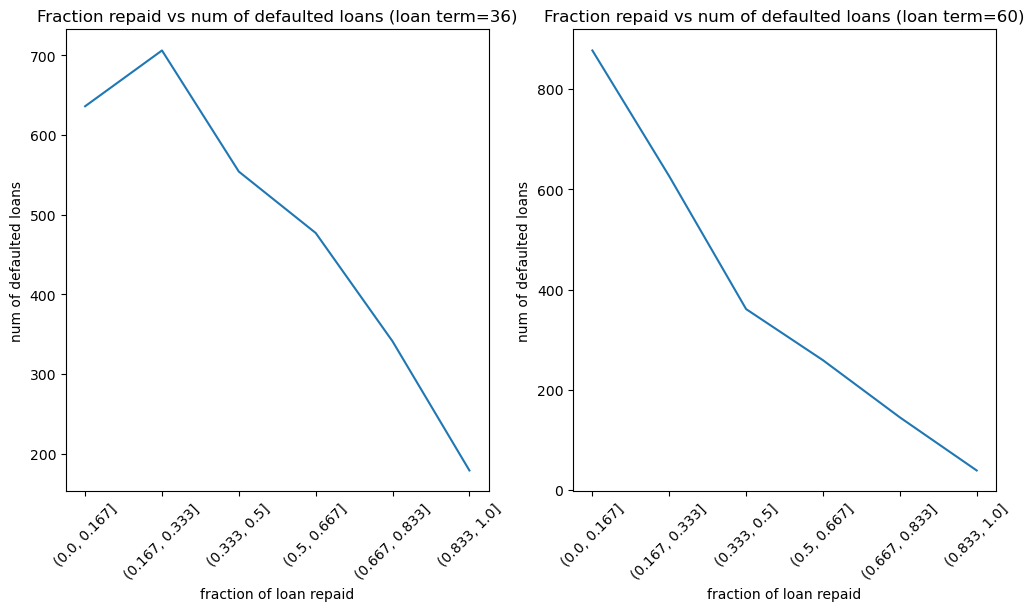

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

defaulted_loans = loan_data_df[loan_data_df.loan_status == 'Charged Off']
pd.cut(defaulted_loans[defaulted_loans.term==36].total_rec_prncp / defaulted_loans[defaulted_loans.term==36].loan_amnt , bins=np.linspace(0,1,7)).value_counts(sort=False).plot.line(rot=45, ax=ax1, xlabel='fraction of loan repaid', ylabel='num of defaulted loans')
ax1.set_title('Fraction repaid vs num of defaulted loans (loan term=36)')

pd.cut(defaulted_loans.total_rec_prncp[defaulted_loans.term==60] / defaulted_loans[defaulted_loans.term==60].loan_amnt , bins=np.linspace(0,1,7)).value_counts(sort=False).plot.line(rot=45, ax=ax2, xlabel='fraction of loan repaid', ylabel='num of defaulted loans')
ax2.set_title('Fraction repaid vs num of defaulted loans (loan term=60)')

# defaulted_loans[['total_pymnt', 'total_rec_prncp', 'out_prncp']]

#### Summary

The probablity of charged off is inversely correlated to the principal received.

-- insight

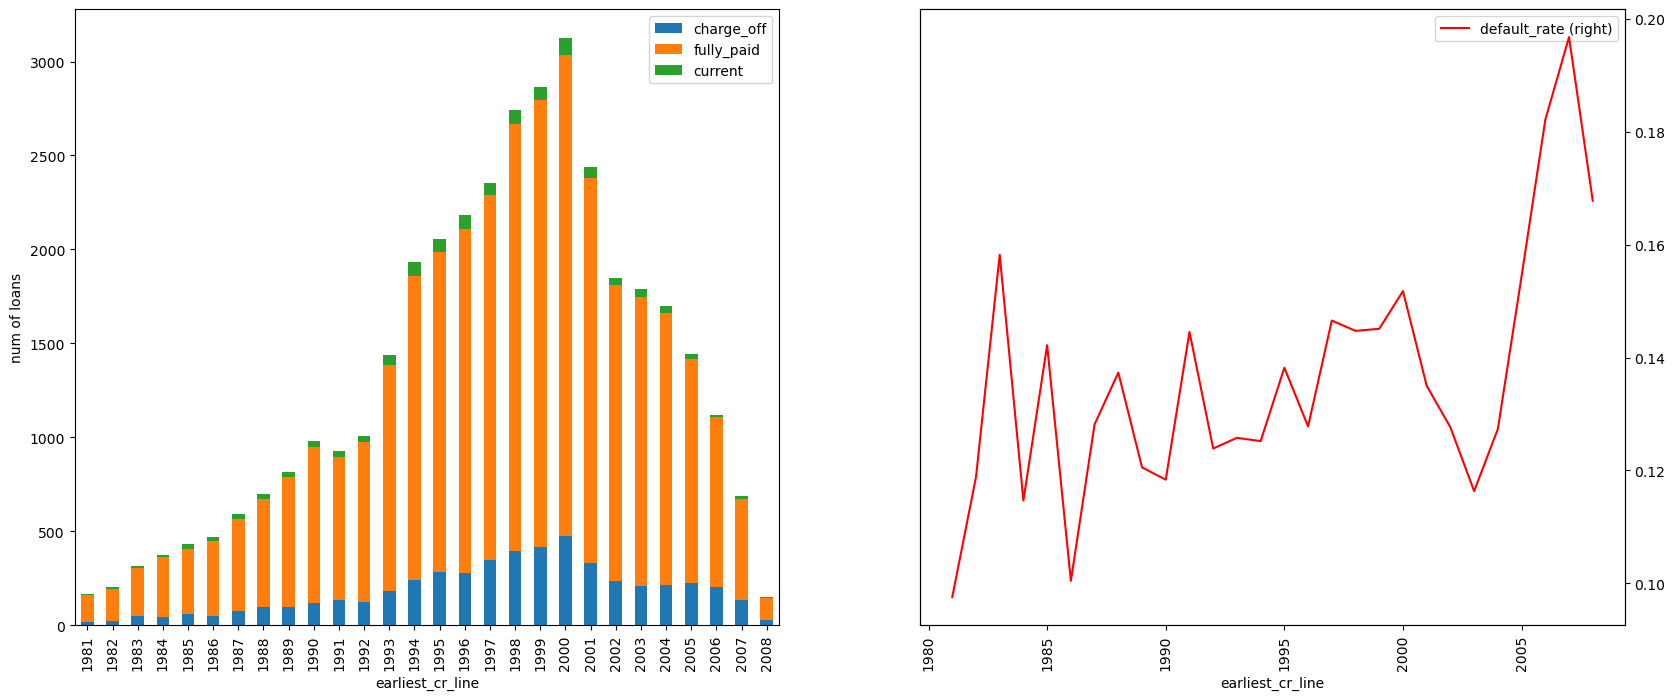

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
loan_data_df[loan_data_df.earliest_cr_line.dt.year>1980].groupby(loan_data_df.earliest_cr_line.dt.year).agg(
                                         charge_off=('loan_status', lambda x: (x=='Charged Off').sum()),
                                         fully_paid=('loan_status', lambda x: (x=='Fully Paid').sum()),
                                         current=('loan_status', lambda x: (x=='Current').sum()),
                                        ).plot.bar(stacked=True, ylabel='num of loans', ax=ax1)

loan_data_df[loan_data_df.earliest_cr_line.dt.year>1980].groupby(loan_data_df.earliest_cr_line.dt.year).agg(default_rate=('loan_status', lambda x: (x=='Charged Off').sum() / x.count())).plot.line(secondary_y='default_rate', ax=ax2, color='r', rot=90)
plt.show()

Text(0.5, 1.0, 'installment/montly_income vs num of defaulted loans')

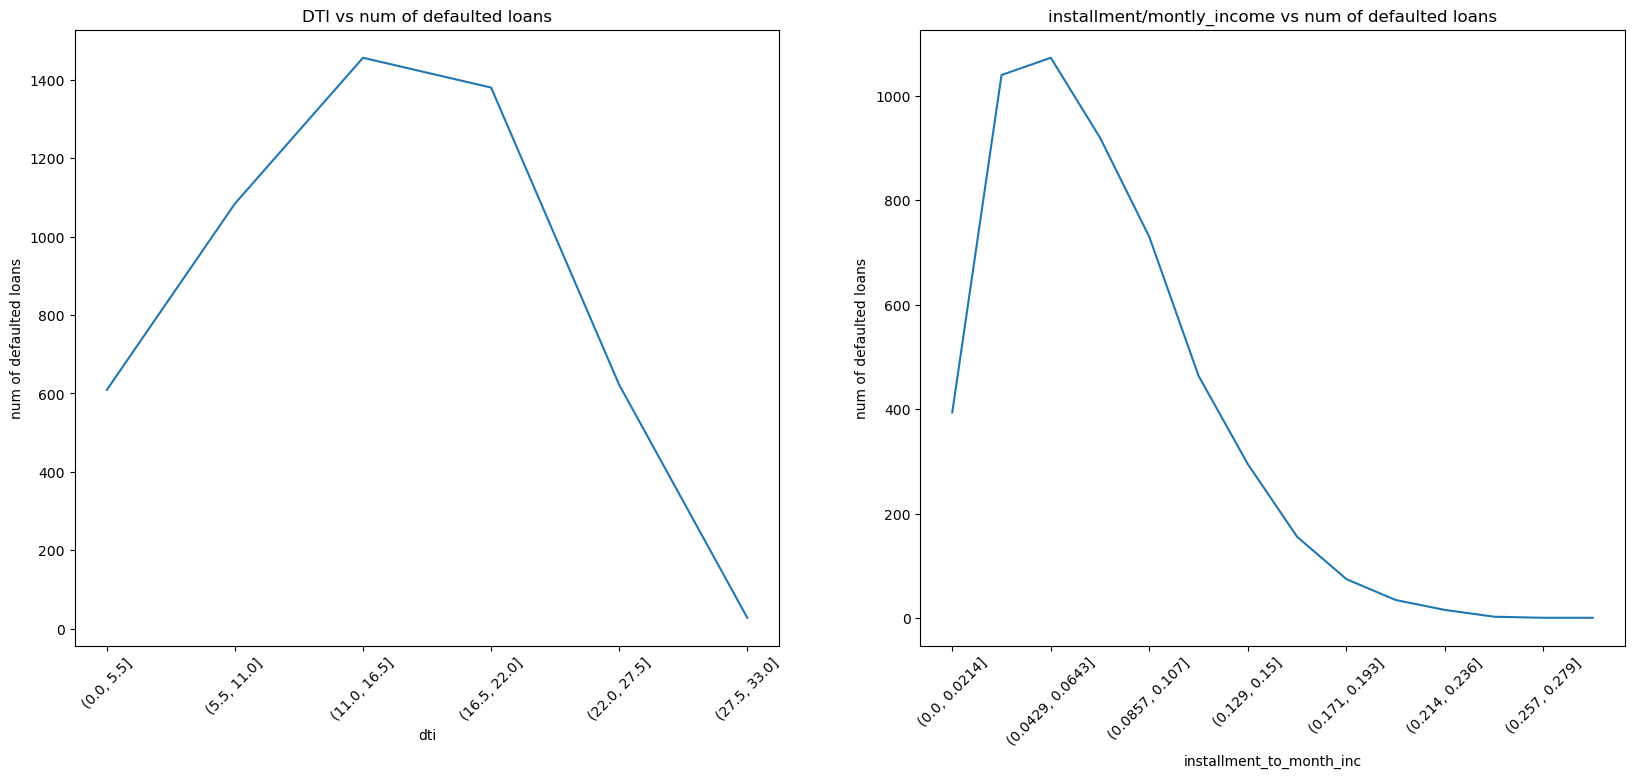

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

defaulted_loans = loan_data_df[loan_data_df.loan_status == 'Charged Off']
pd.cut(defaulted_loans.dti, bins=np.linspace(0,33,7)).value_counts(sort=False).plot.line(rot=45, xlabel='dti', ylabel='num of defaulted loans', ax=ax1)
ax1.set_title('DTI vs num of defaulted loans')

defaulted_loans.installment_to_month_inc.value_counts(sort=False).plot.line(rot=45, xlabel='installment_to_month_inc', ylabel='num of defaulted loans', ax=ax2)
ax2.set_title('installment/montly_income vs num of defaulted loans')

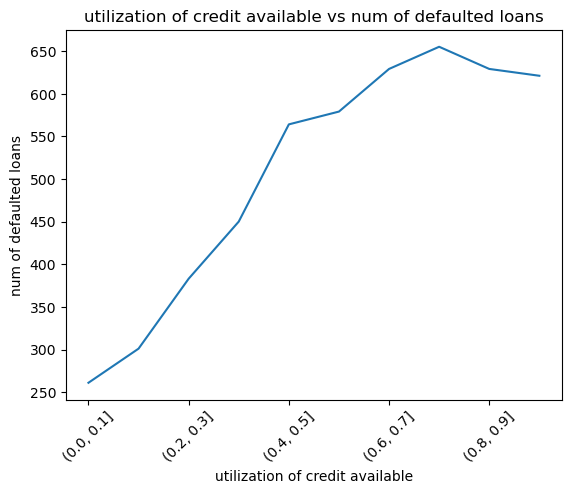

In [45]:
defaulted_loans = loan_data_df[loan_data_df.loan_status == 'Charged Off']
pd.cut(defaulted_loans.revol_util, bins=np.linspace(0,1,11)).value_counts(sort=False).plot.line(rot=45, xlabel='utilization of credit available', ylabel='num of defaulted loans')
plt.title('utilization of credit available vs num of defaulted loans')
plt.show()